In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import glob
import sys

[sys.path.append(f) for f in glob.glob('utils/*')]
from preprocess import DataStruct
from firingrate import raster2FR
from plotting_utils import figSize


from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

files = glob.glob('D:/T5_ClosedLoop/*')

### train linear regression on day 0, test on days 1, 2, ... 

- use 5 ms windows of binned FR activity to estimate cursorErr signal

In [200]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [213]:
dat      = DataStruct(files[2])
window   = 5

n_chans    = dat.TX_continuous.shape[1]
timepoints = dat.TX_continuous.shape[0]
targets    = (dat.targetPos_continuous - dat.cursorPos_continuous)[:(-1 * window), :]
features   = rolling_window(dat.TX_continuous, window = 5).mean(axis = 2)[:(-1 * window), :]

lr         = LinearRegression()
normalizer = StandardScaler()
decoder    = Pipeline([('scaler', StandardScaler()), ('regressor', lr)])
scores = cross_val_score(decoder, features, targets, cv = 10)
print('10-fold cross-validation scores: ', scores)
print('Mean +- SD: ', np.mean(scores), ' +- ', np.std(scores))
decoder.fit(features, targets)

10-fold cross-validation scores:  [0.29895628 0.30751637 0.28511905 0.30884799 0.34540683 0.31440408
 0.37736908 0.3703269  0.33784328 0.34451229]
Mean +- SD:  0.32903021489726003  +-  0.029230710080732736


Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', LinearRegression())])

Text(0.5, 1.0, 'Regression predictions on first 40 seconds of cursor activity')

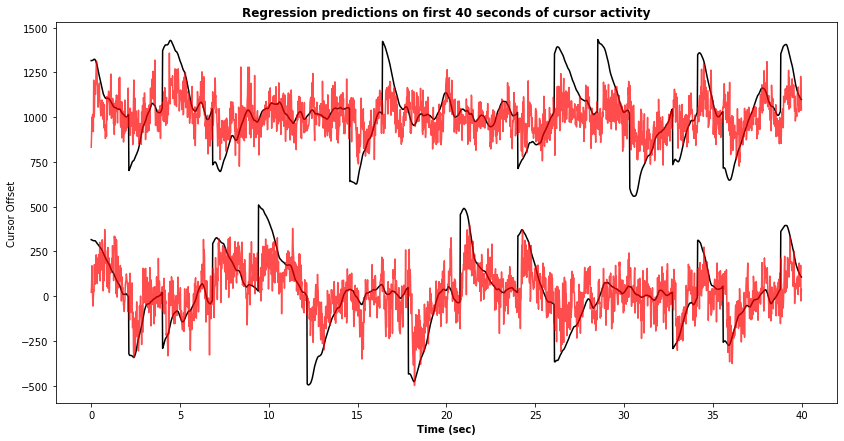

In [203]:
figSize(7, 14)
timelen     = 2000
timestamps  = np.arange(timelen)/ 50 

plt.plot(timestamps, targets[:timelen, 0], color = 'k')
plt.plot(timestamps, targets[:timelen, 1] + 1000, color = 'k')

preds = decoder.predict(features)
plt.plot(timestamps, preds[:timelen, 0], color = 'r', alpha = 0.7)
plt.plot(timestamps, preds[:timelen, 1] + 1000, color = 'r', alpha = 0.7)

#plt.xlabel(plt.x)
ax = plt.gca()
plt.xlabel('Time (sec)', fontweight = 'bold')
plt.ylabel('Cursor Offset')
plt.title('Regression predictions on first 40 seconds of cursor activity', fontweight = 'bold')

In [222]:
from copy import deepcopy

date   = list()
scores = np.zeros((4, 10)) # rows are 0 - no recalibration; 1- z-score recalibration; 2 - regression recalibration; 3 - full recalibration


for i in range(3, 13):
    file = files[i]
    dat  = DataStruct(file)
    date.append(file.split('t5.')[1].split('.mat')[0])
    
    n_chans    = dat.TX_continuous.shape[1]
    timepoints = dat.TX_continuous.shape[0] - window
    targs      = (dat.targetPos_continuous - dat.cursorPos_continuous)[:(-1 * window), :]
    features   = rolling_window(dat.TX_continuous, window = 5).mean(axis = 2)[:(-1 * window), :]
    
    train_x, test_x = features[:int(timepoints/2), :], features[int(timepoints/2):, :]
    train_y, test_y = targs[:int(timepoints/2), :], targs[int(timepoints/2):, :]
    
    # no recalibration
    scores[0, i-3] = decoder.score(test_x, test_y)
    
    # Mean recalibration:
    lr_NormRecal                 = deepcopy(decoder)
    lr_NormRecal['scaler'].mean_ = train_x.mean(axis = 0)
    #lr_NormRecal['scaler'].scale_ = train_x.std(axis = 0)
    scores[1, i-3]               = lr_NormRecal.score(test_x, test_y)
    
    # Coefficients recalibration:
    normed_features =  decoder['scaler'].transform(train_x)
    lr_TuningRecal  =  LinearRegression().fit(normed_features, train_y)
    scores[2, i-3]  = lr_TuningRecal.score(decoder['scaler'].transform(test_x), test_y)
    
    # Full recalibration:
    lr_FullRecal = Pipeline([('scaler', StandardScaler()), ('regressor', LinearRegression())])  
    lr_FullRecal.fit(train_x, train_y)
    scores[3, i-3] = lr_FullRecal.score(test_x, test_y)
    
    
    

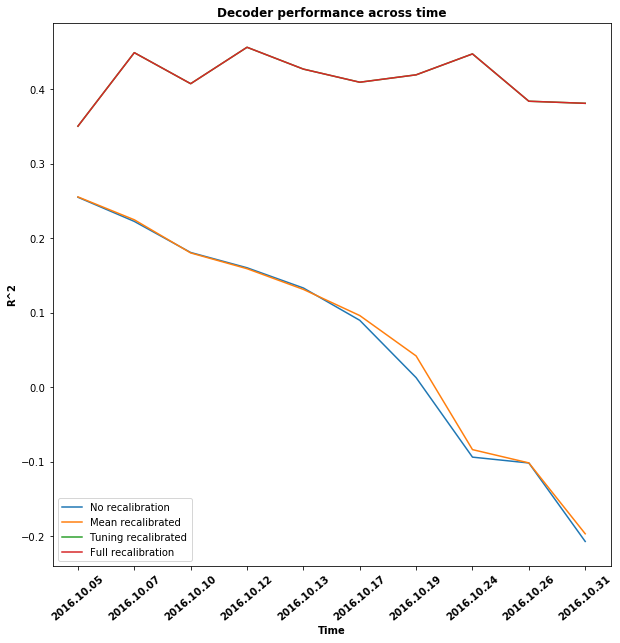

In [223]:
figSize(10, 10)

labels = ['No recalibration', 'Mean recalibrated', 'Tuning recalibrated', 'Full recalibration']
for i in range(4):
    plt.plot(scores[i, :].T, label = labels[i])
    
plt.xlabel('Time', fontweight = 'bold')
plt.ylabel('R^2', fontweight = 'bold')
plt.xticks(np.arange(len(date)), date, rotation = 40, fontweight = 'bold')
plt.title('Decoder performance across time', fontweight = 'bold')
plt.legend()

In [81]:
decoder['regressor'].intercept_

array([2.60016985, 8.59484223])